# Hacienda el Jobo

Caso: Pronosticar la producción de leche

### 1. Importar librerias

In [56]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error

### 2. Carga de datos

In [57]:
df_proyecto = pd.read_csv("/home/daniel/Drive WLS/Cursos/machine-learning/series_de_tiempo/Data/LitrosPorVaca.csv", delimiter=";")
df_proyecto.head()

,Mes,Litros por vaca
0,2007-1,21.6
1,2007-2,20.6
2,2007-3,23.5
3,2007-4,24.1
4,2007-5,26.7


### 3. Tranformacion y limpieza de datos

In [58]:
df_proyecto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Mes              168 non-null    object 
 1   Litros por vaca  168 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [59]:
df_proyecto["Mes"]= pd.to_datetime(df_proyecto["Mes"])
df_proyecto.head()

,Mes,Litros por vaca
0,2007-01-01,21.6
1,2007-02-01,20.6
2,2007-03-01,23.5
3,2007-04-01,24.1
4,2007-05-01,26.7


In [60]:
df_proyecto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mes              168 non-null    datetime64[ns]
 1   Litros por vaca  168 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


In [61]:
df_proyecto.set_index("Mes", inplace=True)
df_proyecto.head()

,Litros por vaca
Mes,
2007-01-01,21.6
2007-02-01,20.6
2007-03-01,23.5
2007-04-01,24.1
2007-05-01,26.7


### 4. Analisis descriptivo

In [62]:
df_proyecto.describe()

,Litros por vaca
count,168.000000
mean,27.698214
std,3.750968
min,20.300000
25%,24.875000
50%,27.950000
75%,30.225000
max,35.600000


<Axes: xlabel='Mes'>

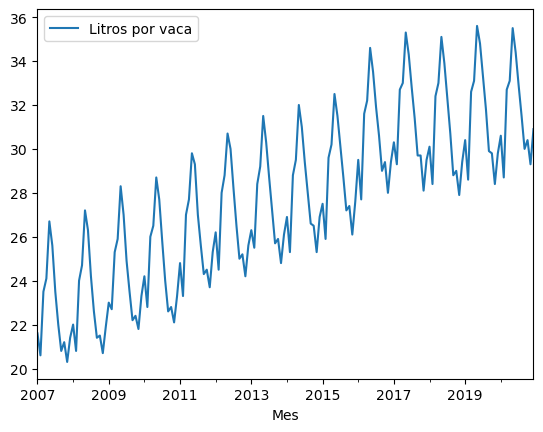

In [63]:
df_proyecto.plot()

In [64]:
serie_de_tiempo = df_proyecto["Litros por vaca"]
type(serie_de_tiempo)

pandas.core.series.Series

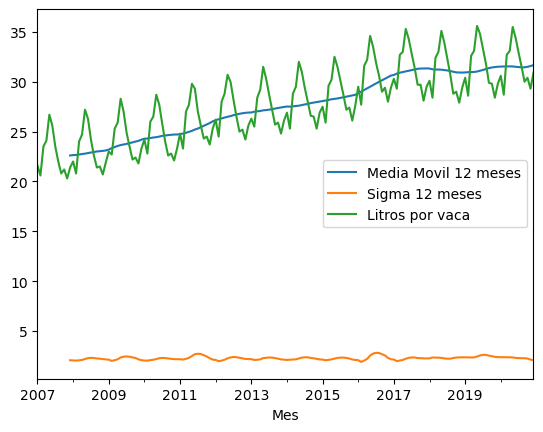

In [65]:
serie_de_tiempo.rolling(12).mean().plot(label="Media Movil 12 meses")
serie_de_tiempo.rolling(12).std().plot(label="Sigma 12 meses")
serie_de_tiempo.plot()
plt.legend()

### 5. Descomposición estacional

In [66]:
estacional = seasonal_decompose(serie_de_tiempo, period=12)

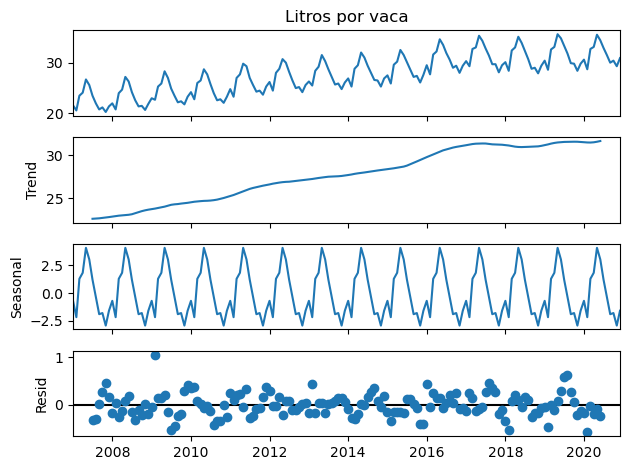

In [67]:
grafico_estacional = estacional.plot()

#### 5.1. Prueba de Dickey-Fuller

La Prueba de Dickey-Fuller Aumentada (ADF, Augmented Dickey-Fuller Test) es una prueba estadística utilizada para determinar si una serie temporal es estacionaria o si tiene una raíz unitaria, lo que indicaría que es no estacionaria.

¿Qué significa que una serie sea estacionaria?
Una serie temporal es estacionaria si sus propiedades estadísticas (como la media, la varianza y la autocorrelación) se mantienen constantes en el tiempo. Esto es importante porque muchos modelos de series temporales, como ARIMA, suponen que los datos son estacionarios.

Ejemplo de series estacionarias y no estacionarias:
Estacionaria: Si una serie oscila alrededor de una media constante con variabilidad estable en el tiempo.
No estacionaria: Si la serie tiene tendencia (crece o decrece con el tiempo) o una varianza cambiante.
¿Cómo funciona la Prueba de Dickey-Fuller?
La prueba ADF evalúa la hipótesis nula (H₀) de que la serie tiene una raíz unitaria, es decir, que no es estacionaria.

Hipótesis nula (H₀): La serie tiene una raíz unitaria (es decir, no estacionaria).

Hipótesis alternativa (H₁): La serie es estacionaria.

Si el p-valor es menor a un umbral (por lo general 0.05), se rechaza H₀, indicando que la serie es estacionaria.

Si el p < 0.05, ¡la serie es estacionaria! y puedes modelar sin transformaciones.

Si el p ≥ 0.05, ¡la serie no es estacionaria!, necesitas aplicar transformaciones antes de modelar.

In [68]:
resultado = adfuller(df_proyecto["Litros por vaca"])
resultado

(-1.2765683449797185,
 0.6398229938263099,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 108.01757657878653)

In [69]:
def prueba_adf(time_series):
    resultado = adfuller(time_series)
    print("Prueba de Dicky-Fuller Aumentado")
    labels = ["Estadistico ADF", "p-value", "# de retrasos", "Observaciones utilizadas"]
    for valor, label in zip(resultado, labels):
        print(label + ":" + str(valor))

    if resultado[1] <= 0.05:
        print("Se rechaza la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("No se puede rechazar hipótesis nula")
        print("Los datos no son estacionarios")

In [70]:
prueba_adf(df_proyecto["Litros por vaca"])

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-1.2765683449797185
p-value:0.6398229938263099
# de retrasos:13
Observaciones utilizadas:154
No se puede rechazar hipótesis nula
Los datos no son estacionarios


Interpretación de los resultados:

Estadístico ADF: Es el valor de la prueba estadística. Cuanto más negativo sea, mayor será la evidencia de estacionariedad.

p-valor: Si es menor que 0.05, rechazamos la hipótesis nula y concluimos que la serie es estacionaria.

Valores críticos: Son los valores de referencia a distintos niveles de confianza (1%, 5%, 10%).

Decisión:

Si el p < 0.05, ¡la serie es estacionaria! y puedes modelar sin transformaciones.

Si el p ≥ 0.05, ¡la serie no es estacionaria!, necesitas aplicar transformaciones antes de modelar..

#### 5.2 Analisis con diferencias

In [71]:
df_proyecto["Primera diferencia"]= df_proyecto["Litros por vaca"]-df_proyecto["Litros por vaca"].shift(1)
df_proyecto.head(5)

,Litros por vaca,Primera diferencia
Mes,,
2007-01-01,21.6,NaN
2007-02-01,20.6,-1.0
2007-03-01,23.5,2.9
2007-04-01,24.1,0.6
2007-05-01,26.7,2.6


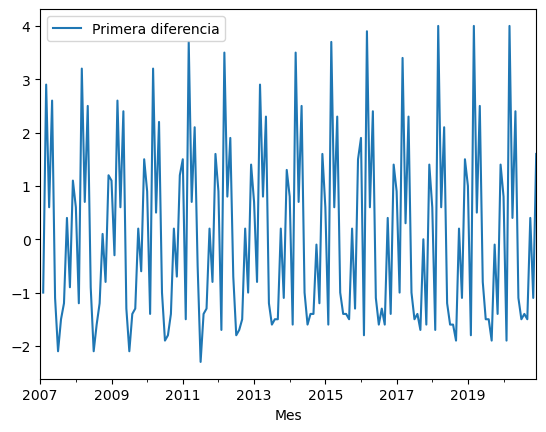

In [72]:
df_proyecto["Primera diferencia"].plot()
plt.legend()
plt.show()

In [73]:
prueba_adf(df_proyecto["Primera diferencia"].dropna())

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-3.040040217307176
p-value:0.031320592024728824
# de retrasos:14
Observaciones utilizadas:152
Se rechaza la hipótesis nula
Los datos son estacionarios


In [74]:
#df_proyecto["Segunda diferencia"]= df_proyecto["Primera diferencia"]-df_proyecto["Primera diferencia"].shift(1)
#df_proyecto.head(5)

In [75]:
#df_proyecto["Segunda diferencia"].plot()
#plt.legend()
#plt.show()

In [76]:
#prueba_adf(df_proyecto["Segunda diferencia"].dropna())

In [77]:
df_proyecto["Diferecnia Estacionalidad"]= df_proyecto["Litros por vaca"]-df_proyecto["Litros por vaca"].shift(12)
df_proyecto.head(5)

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad
Mes,,,
2007-01-01,21.6,NaN,NaN
2007-02-01,20.6,-1.0,NaN
2007-03-01,23.5,2.9,NaN
2007-04-01,24.1,0.6,NaN
2007-05-01,26.7,2.6,NaN


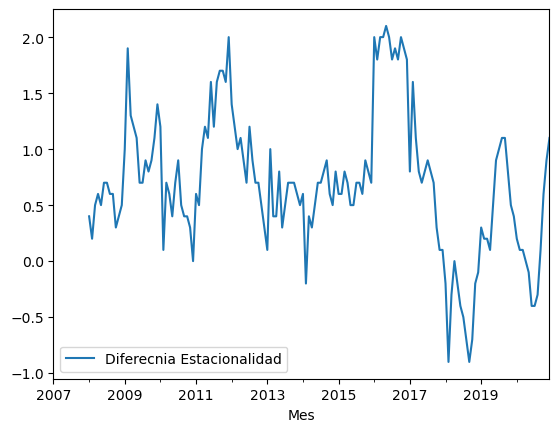

In [78]:
df_proyecto["Diferecnia Estacionalidad"].plot()
plt.legend()
plt.show()

In [79]:
prueba_adf(df_proyecto["Diferecnia Estacionalidad"].dropna())

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-2.440963411044124
p-value:0.13050689595851572
# de retrasos:12
Observaciones utilizadas:143
No se puede rechazar hipótesis nula
Los datos no son estacionarios


In [80]:
df_proyecto["Primera diferencia con estacionalidad"]= df_proyecto["Primera diferencia"]-df_proyecto["Primera diferencia"].shift(12)
df_proyecto.head(5)

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,
2007-01-01,21.6,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN
2007-03-01,23.5,2.9,NaN,NaN
2007-04-01,24.1,0.6,NaN,NaN
2007-05-01,26.7,2.6,NaN,NaN


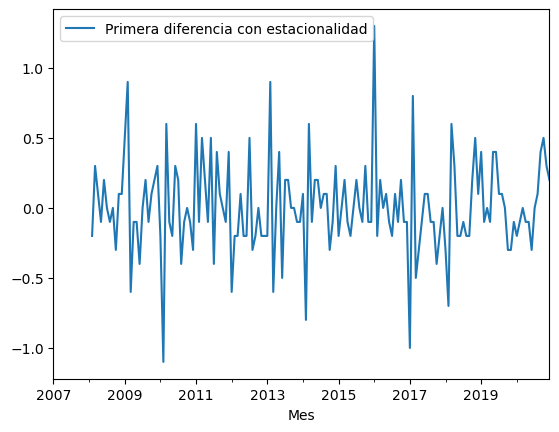

In [81]:
df_proyecto["Primera diferencia con estacionalidad"].plot()
plt.legend()
plt.show()

In [82]:
prueba_adf(df_proyecto["Primera diferencia con estacionalidad"].dropna())

Prueba de Dicky-Fuller Aumentado
Estadistico ADF:-4.87596584180041
p-value:3.883227114341381e-05
# de retrasos:11
Observaciones utilizadas:143
Se rechaza la hipótesis nula
Los datos son estacionarios


### 6. Particion de dataset

In [83]:
df_proyecto

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,
2007-01-01,21.6,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN
2007-03-01,23.5,2.9,NaN,NaN
2007-04-01,24.1,0.6,NaN,NaN
2007-05-01,26.7,2.6,NaN,NaN
...,...,...,...,...
2020-08-01,31.5,-1.4,-0.3,0.1
2020-09-01,30.0,-1.5,0.1,0.4
2020-10-01,30.4,0.4,0.6,0.5


In [84]:
df_train = df_proyecto[0:156]
df_train

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,
2007-01-01,21.6,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN
2007-03-01,23.5,2.9,NaN,NaN
2007-04-01,24.1,0.6,NaN,NaN
2007-05-01,26.7,2.6,NaN,NaN
...,...,...,...,...
2019-08-01,31.8,-1.5,1.1,1.000000e-01
2019-09-01,29.9,-1.9,1.1,-3.552714e-15
2019-10-01,29.8,-0.1,0.8,-3.000000e-01


In [85]:
df_tes = df_proyecto[156:]
df_tes

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,
2020-01-01,30.6,0.8,0.2,-2.000000e-01
2020-02-01,28.7,-1.9,0.1,-1.000000e-01
2020-03-01,32.7,4.0,0.1,3.552714e-15
2020-04-01,33.1,0.4,0.0,-1.000000e-01
2020-05-01,35.5,2.4,-0.1,-1.000000e-01
2020-06-01,34.4,-1.1,-0.4,-3.000000e-01
2020-07-01,32.9,-1.5,-0.4,0.000000e+00
2020-08-01,31.5,-1.4,-0.3,1.000000e-01
2020-09-01,30.0,-1.5,0.1,4.000000e-01


### 7. Seleccion de Términos AR y MA

##### 7.1 Graficos ACF y PACF

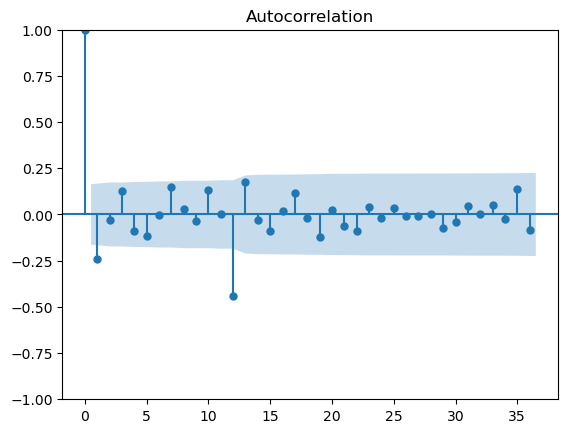

In [86]:
grafico_ACF = plot_acf(df_train["Primera diferencia con estacionalidad"].dropna(), lags=36)

Movil Averange (MA), parametros q y Q

El parámetro q (orden del modelo MA) representa el número de rezagos significativos en la parte de "media móvil" (Moving Average, MA) del modelo ARIMA.

🔹 Regla general: q es el número de rezagos donde la ACF es significativamente diferente de 0 (antes de que se corte abruptamente o se vuelva insignificante).

Si la ACF muestra un corte brusco en el rezago q, significa que un modelo MA(q) puede capturar la relación en la serie. 

Para modelos SARIMA, el parámetro Q representa la parte de media móvil estacional (Seasonal MA).

🔹 Pasos para determinar Q:

Mirar la ACF en los rezagos estacionales (ej., si los datos son mensuales, revisar en lag=12, 24, 36...).
Si en esos rezagos hay valores significativamente altos, el orden estacional Q se elige como el número de lags donde la ACF aún es significativa.
Ejemplo: Si la ACF muestra valores altos en lag=12 y 24 (con datos mensuales), podríamos considerar un modelo con Q=2.

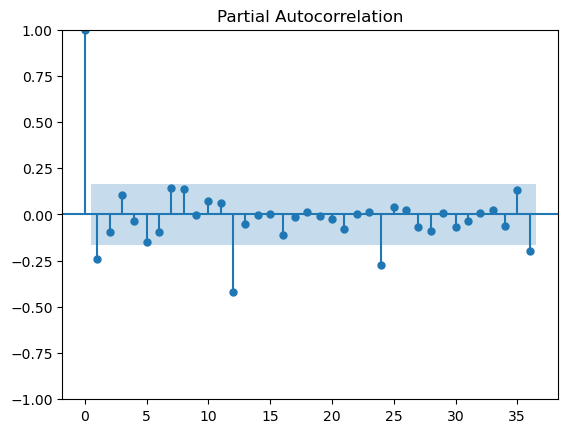

In [87]:
grafico_PACF = plot_pacf(df_train["Primera diferencia con estacionalidad"].dropna(), lags=36)

l PACF (Partial Autocorrelation Function, Función de Autocorrelación Parcial)

El parámetro p en ARIMA representa el número de rezagos en la parte autorregresiva (AR) del modelo.

Regla general: p es el número de rezagos donde la PACF es significativamente diferente de 0 (antes de que se corte abruptamente o se vuelva insignificante).
Si la PACF se corta bruscamente en el rezago p, significa que un modelo AR(p) puede capturar la relación en la serie.

Para modelos SARIMA, el parámetro P representa la parte autorregresiva estacional (Seasonal AR).

🔹 Pasos para determinar P:

Mirar la PACF en los rezagos estacionales (ej., si los datos son mensuales, revisar en lag=12, 24, 36...).
Si en esos rezagos hay valores significativamente altos, el orden estacional P se elige como el número de lags donde la PACF aún es significativa.
Ejemplo: Si la PACF muestra valores altos en lag=12, podríamos considerar un modelo con P=1.

##### 7.2. Parametros ACF y PACF

In [88]:
q = 2 # porque hay dos retrasos estadíticamente significativos en la parte no-estacional de la gráfica (menores que 12)
Q = 3 # porque hay tres retrasos estadísticamente significativos en la parte estacional de la gráfica.
p = 2 # porque hay dos retrasos estadíticamente significativos en la parte no-estacional de la gráfica (menores que 12)
P = 1 # porque hay un retraso estadísticamente significativos en la parte estacional de la gráfica.
d = 1 # Porque para obtener datos estacionarios, estimamos la primera diferencia con estacionalidad.
D = 1 # Porque para obtener datos estacionarios, estimamos la primera diferencia con estacionalidad.
s = 12

#### 8. Modelo S-ARIMA

Fórmula del Modelo SARIMA
El modelo SARIMA (Seasonal Autoregressive Integrated Moving Average) es una extensión del modelo ARIMA que incorpora componentes estacionales. Su notación es:

sm.tsa.statespace.SARIMAX(endog, exog=None, order=(p,d,q), seasonal_order=(P,D,Q,s), ...)

Donde:

p,d,q → Parámetros del modelo ARIMA:

p: Orden autorregresivo (AR).

d: Diferenciación necesaria para hacer la serie estacionaria.

q: Orden de la media móvil (MA).

P,D,Q,s → Parámetros del componente estacional:

P: Orden autorregresivo estacional.

D: Diferenciación estacional.

Q: Orden de la media móvil estacional.

s: Período estacional (ejemplo: 12 para datos mensuales, 4 para trimestrales).

In [89]:
df_train

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,
2007-01-01,21.6,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN
2007-03-01,23.5,2.9,NaN,NaN
2007-04-01,24.1,0.6,NaN,NaN
2007-05-01,26.7,2.6,NaN,NaN
...,...,...,...,...
2019-08-01,31.8,-1.5,1.1,1.000000e-01
2019-09-01,29.9,-1.9,1.1,-3.552714e-15
2019-10-01,29.8,-0.1,0.8,-3.000000e-01


In [90]:
modelo = sm.tsa.statespace.SARIMAX(df_train["Litros por vaca"], order = (2,1,2), seasonal_order = (3,1,1,12))

/home/daniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/daniel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [91]:
resultados = modelo.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51161D-01    |proj g|=  1.00624D+00

At iterate    5    f=  1.02981D-01    |proj g|=  1.94664D-01

At iterate   10    f=  9.56050D-02    |proj g|=  6.22228D-03

At iterate   15    f=  9.50276D-02    |proj g|=  9.27242D-03

At iterate   20    f=  9.48472D-02    |proj g|=  1.84438D-03

At iterate   25    f=  9.48195D-02    |proj g|=  4.21744D-03

At iterate   30    f=  9.48058D-02    |proj g|=  6.78944D-04

At iterate   35    f=  9.47983D-02    |proj g|=  3.50496D-03

At iterate   40    f=  9.47962D-02    |proj g|=  7.13721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [92]:
print(resultados.summary())

                                      SARIMAX Results                                       
Dep. Variable:                      Litros por vaca   No. Observations:                  156
Model:             SARIMAX(2, 1, 2)x(3, 1, [1], 12)   Log Likelihood                 -14.788
Date:                              Thu, 17 Apr 2025   AIC                             47.576
Time:                                      06:42:52   BIC                             74.242
Sample:                                  01-01-2007   HQIC                            58.412
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4054      0.389     -1.043      0.297      -1.168       0.357
ar.L2         -0.57

In [93]:
resultados.resid

Mes
2007-01-01    21.600000
2007-02-01    -1.000000
2007-03-01     2.900000
2007-04-01     0.600000
2007-05-01     2.600000
                ...    
2019-08-01    -0.044901
2019-09-01    -0.240057
2019-10-01    -0.313865
2019-11-01    -0.145346
2019-12-01    -0.079878
Length: 156, dtype: float64

<Axes: xlabel='Mes'>

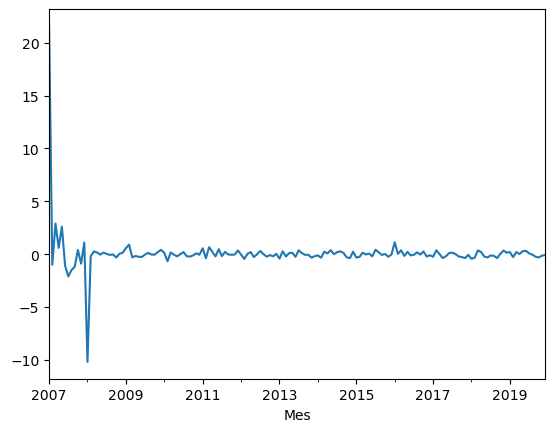

In [94]:
resultados.resid.plot()

##### 8.1. Pronosticos

In [95]:
df_train.head()

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad
Mes,,,,
2007-01-01,21.6,NaN,NaN,NaN
2007-02-01,20.6,-1.0,NaN,NaN
2007-03-01,23.5,2.9,NaN,NaN
2007-04-01,24.1,0.6,NaN,NaN
2007-05-01,26.7,2.6,NaN,NaN


In [96]:
df_train["Pronostico"]= resultados.predict()

/tmp/ipykernel_1895/1934460348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Pronostico"]= resultados.predict()


In [97]:
df_train

,Litros por vaca,Primera diferencia,Diferecnia Estacionalidad,Primera diferencia con estacionalidad,Pronostico
Mes,,,,,
2007-01-01,21.6,NaN,NaN,NaN,0.000000
2007-02-01,20.6,-1.0,NaN,NaN,21.600000
2007-03-01,23.5,2.9,NaN,NaN,20.600000
2007-04-01,24.1,0.6,NaN,NaN,23.500000
2007-05-01,26.7,2.6,NaN,NaN,24.100000
...,...,...,...,...,...
2019-08-01,31.8,-1.5,1.1,1.000000e-01,31.844901
2019-09-01,29.9,-1.9,1.1,-3.552714e-15,30.140057
2019-10-01,29.8,-0.1,0.8,-3.000000e-01,30.113865


<Axes: xlabel='Mes'>

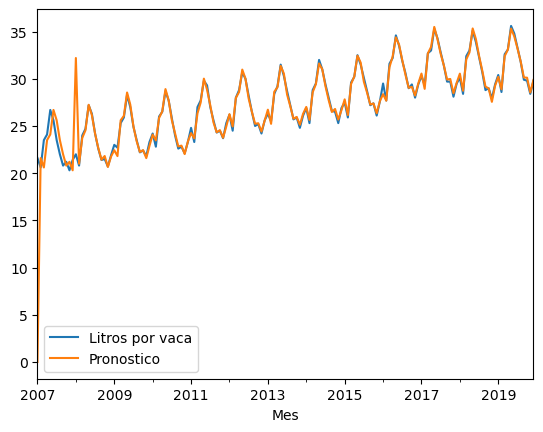

In [98]:
df_train[["Litros por vaca", "Pronostico"]].plot()

In [99]:
fechasfuturas = [df_train.index[-1] + DateOffset(months=x) for x in range(1,13)]
fechasfuturas

[Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-12-01 00:00:00')]

In [100]:
df_futuras = pd.DataFrame(
    index=fechasfuturas, 
    columns=["Litros por vaca", "Pronostico"])
df_futuras

,Litros por vaca,Pronostico
2020-01-01,NaN,NaN
2020-02-01,NaN,NaN
2020-03-01,NaN,NaN
2020-04-01,NaN,NaN
2020-05-01,NaN,NaN
2020-06-01,NaN,NaN
2020-07-01,NaN,NaN
2020-08-01,NaN,NaN
2020-09-01,NaN,NaN
2020-10-01,NaN,NaN


In [101]:
df_pronostico = pd.concat([df_train[["Litros por vaca"]], df_futuras[["Litros por vaca","Pronostico"]]])
df_pronostico

,Litros por vaca,Pronostico
2007-01-01,21.6,NaN
2007-02-01,20.6,NaN
2007-03-01,23.5,NaN
2007-04-01,24.1,NaN
2007-05-01,26.7,NaN
...,...,...
2020-08-01,NaN,NaN
2020-09-01,NaN,NaN
2020-10-01,NaN,NaN
2020-11-01,NaN,NaN


In [102]:
df_pronostico["Pronostico"] = resultados.predict(start = 156, end = 168)
df_pronostico

,Litros por vaca,Pronostico
2007-01-01,21.6,NaN
2007-02-01,20.6,NaN
2007-03-01,23.5,NaN
2007-04-01,24.1,NaN
2007-05-01,26.7,NaN
...,...,...
2020-08-01,NaN,32.116727
2020-09-01,NaN,30.333612
2020-10-01,NaN,30.474547
2020-11-01,NaN,29.118427


In [103]:
df_pronostico[["Pronostico"]].tail(12)

,Pronostico
2020-01-01,31.013349
2020-02-01,29.306233
2020-03-01,33.222989
2020-04-01,33.757607
2020-05-01,36.121223
2020-06-01,35.118662
2020-07-01,33.562151
2020-08-01,32.116727
2020-09-01,30.333612
2020-10-01,30.474547


<Axes: >

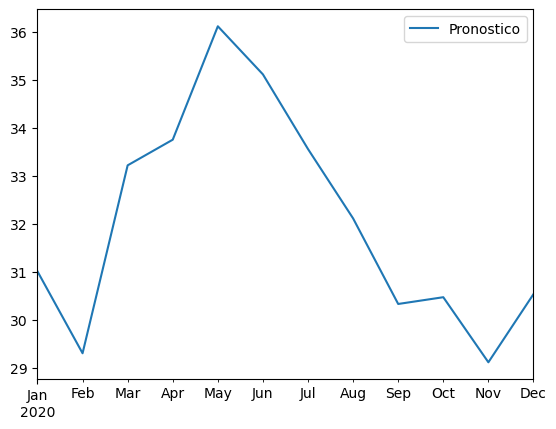

In [104]:
df_pronostico[["Pronostico"]].tail(12).plot()

<Axes: >

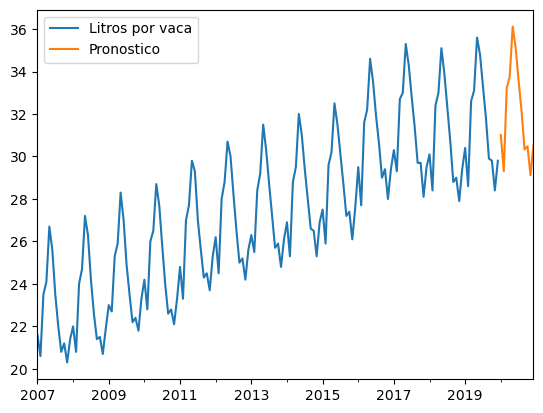

In [105]:
df_pronostico[["Litros por vaca", "Pronostico"]].plot()

##### 8.2. Validación del Modelo

In [118]:
df_validacion = pd.concat([
    df_tes[["Litros por vaca"]],
    df_pronostico.iloc[156:168][["Pronostico"]]
], axis=1)

df_validacion.head(24)

,Litros por vaca,Pronostico
2020-01-01,30.6,31.013349
2020-02-01,28.7,29.306233
2020-03-01,32.7,33.222989
2020-04-01,33.1,33.757607
2020-05-01,35.5,36.121223
2020-06-01,34.4,35.118662
2020-07-01,32.9,33.562151
2020-08-01,31.5,32.116727
2020-09-01,30.0,30.333612
2020-10-01,30.4,30.474547


In [129]:
# Calcular residuo entre valor real y pronóstico
df_validacion["Residuo"] = df_validacion["Litros por vaca"] - df_validacion["Pronostico"].round(2)

# Calcular el error porcentual absoluto (ACC) y manejar división por cero
df_validacion["ACC"] = (
    (df_validacion["Residuo"] / df_validacion["Pronostico"].replace(0, np.nan)) * 100
).round(2)

df_validacion.head(24)

,Litros por vaca,Pronostico,Residuo,ACC
2020-01-01,30.6,31.013349,-0.41,-1.32
2020-02-01,28.7,29.306233,-0.61,-2.08
2020-03-01,32.7,33.222989,-0.52,-1.57
2020-04-01,33.1,33.757607,-0.66,-1.96
2020-05-01,35.5,36.121223,-0.62,-1.72
2020-06-01,34.4,35.118662,-0.72,-2.05
2020-07-01,32.9,33.562151,-0.66,-1.97
2020-08-01,31.5,32.116727,-0.62,-1.93
2020-09-01,30.0,30.333612,-0.33,-1.09
2020-10-01,30.4,30.474547,-0.07,-0.23


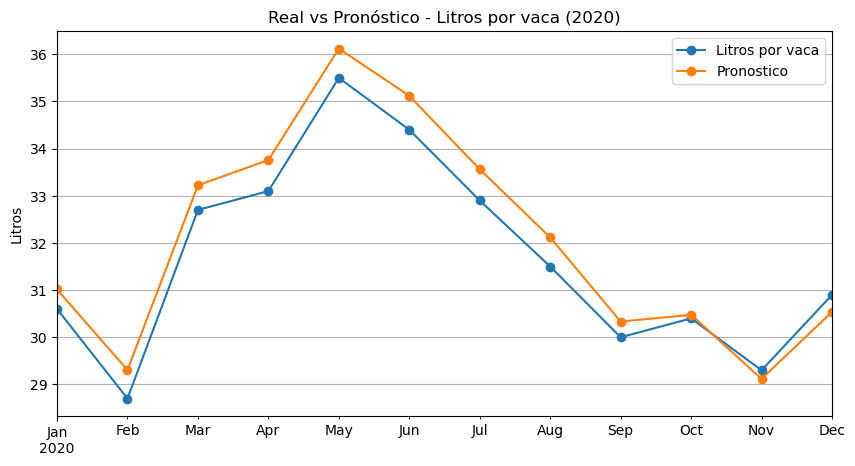

In [135]:
df_validacion[["Litros por vaca", "Pronostico"]].plot(figsize=(10,5), marker='o')
plt.title("Real vs Pronóstico - Litros por vaca (2020)")
plt.ylabel("Litros")
plt.grid(True)
plt.show()


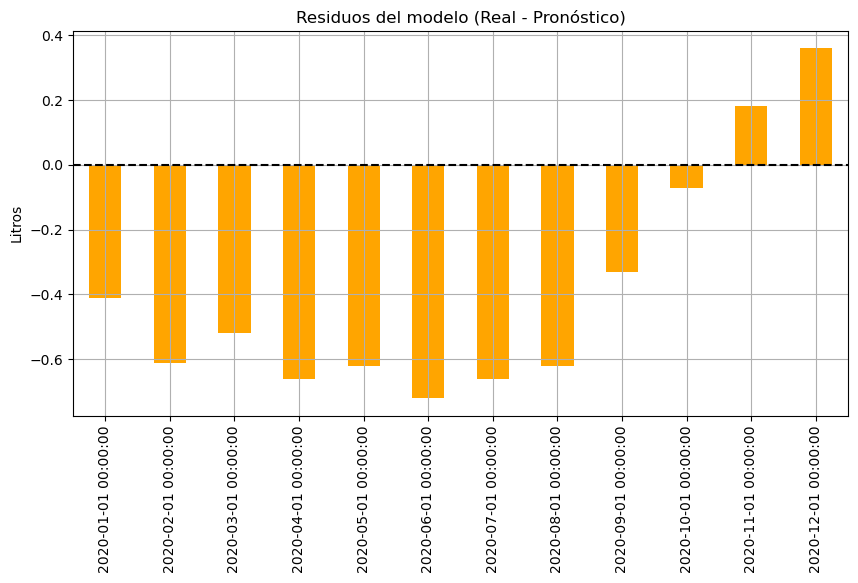

In [136]:
df_validacion["Residuo"].plot(kind="bar", figsize=(10, 5), color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuos del modelo (Real - Pronóstico)")
plt.ylabel("Litros")
plt.grid(True)
plt.show()

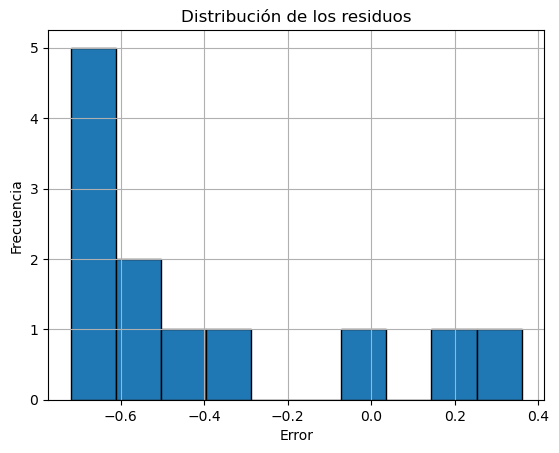

In [137]:
df_validacion["Residuo"].hist(bins=10, edgecolor='black')
plt.title("Distribución de los residuos")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

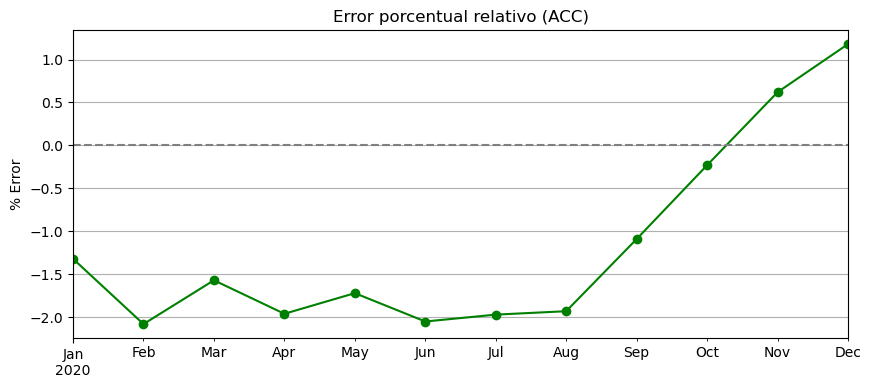

In [138]:
df_validacion["ACC"].plot(kind="line", marker='o', figsize=(10, 4), color='green')
plt.axhline(0, linestyle="--", color='gray')
plt.title("Error porcentual relativo (ACC)")
plt.ylabel("% Error")
plt.grid(True)
plt.show()

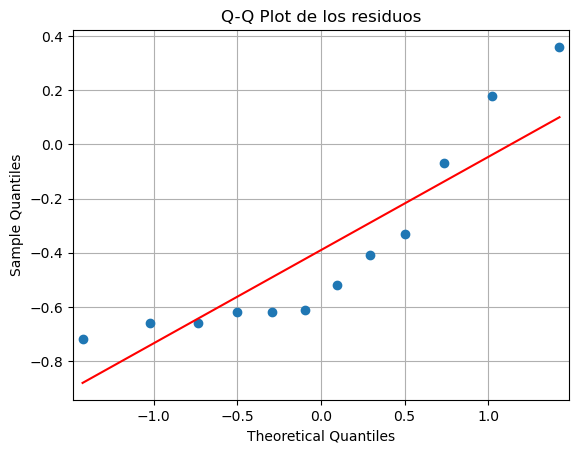

In [141]:
import statsmodels.api as sm
sm.qqplot(df_validacion["Residuo"], line='s')
plt.title("Q-Q Plot de los residuos")
plt.grid(True)
plt.show()

🔹 MAPE (Mean Absolute Percentage Error)

In [132]:
mape = df_validacion["ACC"].abs().mean()
print(f"MAPE promedio: {mape:.2f}%")


MAPE promedio: 1.48%


🔹 RMSE (Root Mean Squared Error)

In [133]:
rmse = np.sqrt(mean_squared_error(df_validacion["Litros por vaca"], df_validacion["Pronostico"]))
print(f"RMSE: {rmse:.2f} litros")

RMSE: 0.52 litros
